DISCLAIMER

The following software is provided for private use only and it comes as is - with no warranty explicit or implied.

Built with open-source libraries by Giulio Giorcelli, Data Scientist and AI researcher. 

Welcome to this computer vision tutorial! By following this iPython workbook you will learn how to develop, train and use an image classifier in Tensorflow with real-world data and optimized code that you can use for you own projects. With minimal effort and a basic architecture, you convolutional neural network will indetify cats, dogs and pandas with an average accuracy north of 75%. You can download the dataset used for this tutorial at this link: https://drive.google.com/drive/folders/1ovJ1p2egrezfdyJ1I4E9Pjk1_rpLwfNe?usp=sharing

Deep learning alorithms are never implemented in iPython, however these notebooks make for great learning platforms as they allow you to see what the code is doing at each step. Hopefully after this tutorial you will be able to build your own computer vision algorithms with self-standing scripts.

In order to get the most out of this tutorial you will need a solid understanding of python programming, machine learning, aritificial neural networks and, more specifically, convolutional neural networks. Copy-and-paste data science will not take you anywhere, so please take your time to study the mechanics of these algorithms before moving forward.

Let's get started!

First of all, let's import all the necessary libraries. If you haven't installed them yet a simple 'pip install package_name' should do the trick. If you run into any difficulties please Google the error and you'll find the solution on either GitHub or Stack Overflow.

In [1]:
%matplotlib inline

from __future__ import division, print_function, absolute_import

import tensorflow as tf
import matplotlib.pyplot as plt

import cv2
import os
import time
import numpy as np
import skimage
import imutils

from datetime import timedelta
from imutils import paths
from skimage import transform
from scipy.misc import imread, imresize
from keras.preprocessing.image import img_to_array

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Now let's specify the path where we keep our images (available for download on this GitHub). You should keep your images for each animal in saparate folders so that it will be easier to grab the correct labels by parsing out the path.

In [7]:
#Data path
path = 'C:\\Users\\ggiorcelli\\computer_vision\\datasets\\animals\\'
image_paths = list(paths.list_images(path))

The *load* function below creates two empty lists to which the images and their corresponding labels will be appended as they are loaded.

You can see on line 6 how we grab the label by parsing out the path.
With this line of code: *label = image_path.split(os.path.sep)[-2]* we are parsing out the second to last element of the path of each image. Given that the path looks like this: "C:\\Users\\ggiorcelli\\computer_vision\\datasets\\animals\\*animal type*\\image_n.jpg we are using the aforementioned code to grab the *animal type* part of the path for each image that we importing. Remember that in this case *animal type* can be "dogs", "cats" or "pandas"

If this explanation is still not clear, below is graphical representation of how the folders are organized.

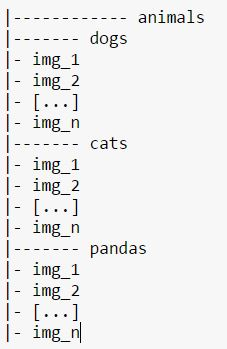

In [9]:
from IPython.display import Image
Image(filename = 'C:\\Users\\ggiorcelli\\Pictures\\folder_structure.jpg', width=150, height=300)

In [5]:
def load(image_paths, verbose=-1):
    data=[]
    labels=[]
    
    for (i, image_path) in enumerate(image_paths):
        image = cv2.imread(image_path)
        label = image_path.split(os.path.sep)[-2]
    
        data.append(image)
        labels.append(label)
        
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("Image loaded {}/{}".format(i + 1,len(image_paths)))

        
    return (np.array(data), np.array(labels))

Let's call the function with verbose = 500 so that it prints out an update every 500 samples

In [8]:
(data, labels) = load(image_paths, verbose=500)

Image processed 500/3000
Image processed 1000/3000
Image processed 1500/3000
Image processed 2000/3000
Image processed 2500/3000
Image processed 3000/3000


Run the code below to take a look at image number 1 and its corresponsing label

Category:  cats


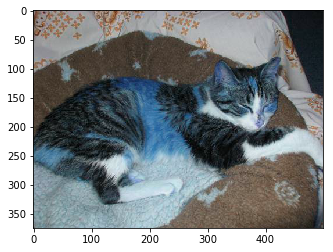

In [5]:
print("Category: ", labels[1])
plt.imshow(data[1])

In computer vision, models can only be trained with images of the same shape. For this tutorial we will give all of our images the following shape (64, 64, 3) where the first number is the height, the second number is the width and the third number is for the color channels, in this case 3 as we are in the RGB spectrum.

We could technically resize our image with this one one-liner: skimage.transform.resize(image[i], (64, 64), mode='reflect')
However this method would distort all the images that are not perfectly squared, so we will need to use the *resize_images* function to properly resize all the images, including those with a rectangular shape, so that all their proportions remain intact.

The function below does just that. It might look convoluted but all it does is calculate the delta between height and width and use that delta to resize the image proportionally. If you need more help understanding this function I suggest you run every line separately to see their individual effect.

In [7]:
def resize_images(images, width, height, verbose=-1):
    
    resized_images = []
    
    for i in range(len(images)):
        (h, w) = images[i].shape[:2]
        inter = cv2.INTER_AREA
        dW = 0
        dH = 0
        
        if w < h:
            image = imutils.resize(images[i], width=width, inter=inter)
            dH = int((image.shape[0] - height) / 2.0)
            
        else:
            image = imutils.resize(images[i], height=height, inter=inter)
            dW = int((image.shape[1] - width) / 2.0)

        (h, w) = image.shape[:2]
        image = image[dH:h - dH, dW:w - dW]

        image = cv2.resize(image, (width, height), interpolation=inter)
        resized_images.append(image)
        
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("Images resized {}/{}".format(i + 1,len(images)))
        
    return(np.array(resized_images))

Let's apply the function to our data.

In [8]:
resized_images = resize_images(data, 64, 64, verbose=500)

Images resized 500/3000
Images resized 1000/3000
Images resized 1500/3000
Images resized 2000/3000
Images resized 2500/3000
Images resized 3000/3000


Now that our images are resized, we need to process them into the right format. In computer vision, we need to turn images into Numpy arrays. It's also necessary to normalize the pixel intensity so that their value is always between 0 and 1. Given that the maximum pixel intesity is 255, we can achieve that simply by dividing each pixel (now array elements) by 255.

There are other normalizations techniques that can be applied to images, however the model that we will build for this tutorial is fairly simple and even with additional normalization I doubt that the accuracy would improve by a noticeable magnitute. You are encouraged to do your own research on this topic and to test the difference on your models. I will probably cover advanced image normalization in a future tutorial.

In [9]:
def process_image(images, verbose=-1):
    
    processed_images = []
    
    for i in range(len(images)):
        processed = img_to_array(images[i])        # transforming images to numpy arrays
        processed = processed / 255.0              # scaling pixel intesity between 0 and 1
        processed_images.append(processed)
        
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("Images processed {}/{}".format(i + 1,len(images)))
    
    return(np.array(processed_images))

Let's call the function we just wrote on our previously resized images.

In [10]:
processed_images = process_image(resized_images, verbose=500)

Images processed 500/3000
Images processed 1000/3000
Images processed 1500/3000
Images processed 2000/3000
Images processed 2500/3000
Images processed 3000/3000


Now that all images are resized and processed, we need to shuffle them before we can split them between the train and test set. Remeber from earlier that due to the folder structure the images are ordered by class. So if we do not randomize their order the model will see all the cats first, then it will see all the dogs and finally all the pandas. This would severly impact the ability of the model to generalize on unseen data, therefore we need to make sure that our data is randomly distributed.

We are going to randomize our data with the *shuffle* function. Keep in mind that when I'm writing this tutorial (01/15/2018) scientists have still to figure out a randomization algorithm that ensures true randomization. Shuffling the data once will not ensure randomness so reccoend to run this cell at least three times before you split it before train and test. The side effect of doing this is that our results will slightly differ as your model will be trained with different images.

In [11]:
processed_images, labels = shuffle(processed_images, labels) #called three times

Below we split the data between train and test, allocating 10% of the images to the test set.

In [12]:
trainX, testX, trainY, testY = train_test_split(processed_images, labels, test_size=0.10, random_state=42)

Before we train our model, we need augment our images. Image augmentation consists in applying small changes to our images so that the model will generalize better on unseen data. The function below takes one image at a time, creates an horizontally flipped copy of the original and then applies random rotations, zooms, shifts and shears to both images. 

The argument *augmentation_factor* determines how many times those random changes will be applied. 1 should almost always be ok as it creates a total of nine edited images for each image, so after calling *augment_images* one one image you will have a total of 10 output images.

Although it is a lot of code the function itself is very straight forward. If you are confused you can run it section by section on one image to see how it works.

In [13]:
def augment_images(data, data_labels, augementation_factor=1, random_rotation=True, flip_image=True,
                   random_shear=True, random_shift=True, random_zoom=True, verbose=-1):
    
    images = []
    labels = []
    
    # Create a copy of the original images and flip the orginal image horziontally. 
    # This will duplicate the size of our train set.
    
    for idx in range(len(data)):
        images.append(data[idx])
        labels.append(data_labels[idx])
        if flip_image:
            images.append(tf.keras.preprocessing.image.flip_axis(data[idx], axis=1))
            labels.append(data_labels[idx])
    
    images, labels = np.array(images), np.array(labels)
            
    augmented_images = []
    augmented_image_labels = []        
    
    for i in range(len(images)):
        
        augmented_images.append(images[i])
        augmented_image_labels.append(labels[i])
        
        for new_img in range(0, augementation_factor):

            if random_rotation:
                augmented_images.append(tf.keras.preprocessing.image.random_rotation(images[i], 35, 
                                                                         row_axis=0, col_axis=1, channel_axis=2))
                augmented_image_labels.append(labels[i])

            if random_shear:
                augmented_images.append(tf.keras.preprocessing.image.random_shear(images[i], 0.2, 
                                                                         row_axis=0, col_axis=1, channel_axis=2))
                augmented_image_labels.append(labels[i])

            if random_shift:
                augmented_images.append(tf.keras.preprocessing.image.random_shift(images[i], 0.1, 0.1,
                                                                         row_axis=0, col_axis=1, channel_axis=2))
                augmented_image_labels.append(labels[i])

            if random_zoom:
                augmented_images.append(tf.keras.preprocessing.image.random_zoom(images[i], (0.8, 1), 
                                                                         row_axis=0, col_axis=1, channel_axis=2,
                                                                         fill_mode = 'nearest'))
                augmented_image_labels.append(labels[i])
                
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("Images processed {}/{}".format(i + 1,len(images)))      

    print("Image aumentation completed.")        
    return np.array(augmented_images), np.array(augmented_image_labels)

Calling the function:

In [14]:
trainX_aug, trainY_aug = augment_images(trainX, trainY, verbose=500)

Images processed 500/5400
Images processed 1000/5400
Images processed 1500/5400
Images processed 2000/5400
Images processed 2500/5400
Images processed 3000/5400
Images processed 3500/5400
Images processed 4000/5400
Images processed 4500/5400
Images processed 5000/5400
Image aumentation completed.


As you can see our train set has increased by 10X in size 

In [359]:
print("# of images before augmentation: ", len(trainX))
print("# of images after augmentation: ", len(trainX_aug))

# of images before augmentation:  2700
# of images after augmentation:  27000


It is time to start building our model. Let's begin by defining some hyperparameters. We might end up not using them as this is a tutorial, but I think it is still good practice to write them in a cell as they are easier to refer to in case we forget.

I'm not going to go over concepts like learning rate, dropout and batch size as you should already be familiar with all of this. If you're not, please do yourself a favor and study the fundamentals of machine learning and deep learning before continuing.

In [188]:
# Training Parameters
learning_rate = 0.001
batch_size = 128
dropout = 0.25

# Network Parameters
height = 64
width = 64
channels = 3

num_input = 12288 # flatten img shape: 64*64*3
num_classes = 3 # 3 classes: cats, dogs, pandas

Tensorflow works with computational graphs, meaning that we have to build the entire model and precompute all the functions using placeholders before we catually train it. It will become clearer as you follow along. For more information on Tensorflow pleas refer to the original documentation.

Let's start by defining the placeholders for our images of shape height, width and number of channels(64, 64, 3), our labels of shape 3 as our three classes and a boolean *training* that we will use later on.

You have probably noticed that we have one extra dimension, currently occupied by *None*. That extra dimension represents the number of elements that we are computing. For example, if we have 100 images of shape 64, 64 and 3 the shape for that batch of images will be (100, 64, 64, 3) and the shape for their labels will be (100, 3).

In [189]:
images_placeholder = tf.placeholder(tf.float32, shape=[None, 64, 64, 3], name='images_placeholder')
labels_placeholder = tf.placeholder(tf.int64, shape=[None, 3], name='labels_placeholder')
training = tf.placeholder(tf.bool, name='training')

The palceholders are defined, we now have to build the architecture of our model.

We will build a mignature version of the VGGNet algorithm, stacking two convolutional layers with same filter volume and size before max pooling and applying dropout. This operation will include batch normalization and it will repeated twice before flattening the data and passing it through two fully-connected layers of 1024 neurons each with batch normalization and accelerated dropout. Please refer to the VGGNet paper for additional information.

I am assuming that you are familiar with convolutional neural network and the mechanics of all the functions listed below so I will not cover them in this tutorial. Their names are self explenatory so I will not introduce them one by one to you. You are encourage to look them up on the official Tensorflow documentation if you have any doubts.

In [190]:
# Create the neural network
def conv_net(x, reuse=tf.AUTO_REUSE):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=tf.AUTO_REUSE):

        # -- FIRST BLOCK --
        # Two convolutional layers with 32 filters, size of 3, padding = 'same', stride of 1
        # Batch normalization at every convolutional layer
        # One max-pool layer 2X2
        # One dropout layer at the end
        conv1 = tf.layers.conv2d(x, 32, 3, activation=tf.nn.relu, padding='SAME', name='conv1')
        conv1 = tf.layers.batch_normalization(conv1,training=training)
        conv2 = tf.layers.conv2d(conv1, 32, 3, activation=tf.nn.relu, padding='SAME', name='conv2')
        conv2 = tf.layers.batch_normalization(conv2, training=training)
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)
        conv2 = tf.layers.dropout(conv2, rate=dropout)
        
        # -- SECOND BLOCK --
        # Two convolutional layers with 32 filters, size of 3, padding = 'same', stride of 1
        # Batch normalization at every convolutional layer
        # One max-pool layer 2X2
        # One dropout layer at the end
        conv3 = tf.layers.conv2d(conv2, 32, 3, activation=tf.nn.relu, padding='SAME', name='conv3')
        conv3 = tf.layers.batch_normalization(conv3, training=training)
        conv4 = tf.layers.conv2d(conv3, 32, 3, activation=tf.nn.relu, padding='SAME', name='conv4')
        conv4 = tf.layers.batch_normalization(conv4, training=training)
        conv4 = tf.layers.max_pooling2d(conv4, 2, 2)
        conv4 = tf.layers.dropout(conv4, rate=dropout)
        
        # Flatten the data to a 1-D vector for fully connected layers
        fc1 = tf.contrib.layers.flatten(conv4)
        
        # -- FULLY CONNECTED BLOCK --
        # Two fully connected layers with 1024 neurons
        # Batch normalization and 1.25x dropout rate on each layer
        fc1 = tf.layers.dense(fc1, 1024)
        fc1 = tf.layers.batch_normalization(fc1, training=training)
        fc1 = tf.layers.dropout(fc1, rate=dropout*1.25)
        fc2 = tf.layers.dense(fc1, 1024)
        fc2 = tf.layers.batch_normalization(fc2, training=training)
        fc2 = tf.layers.dropout(fc2, rate=dropout*1.25)
        
        # Output layer
        out = tf.layers.dense(fc2, num_classes)

    return out

The function below is a small one liner with it is one the main pillars of this CNN. It precomputes the output of the network - the logits - and it stores the into a variable that will be used to calculate the cross-entropy and derive the predictions.

In [ ]:
logits_out = conv_net(images_placeholder, reuse=tf.AUTO_REUSE)

We now need to grab the acutal predictions from the logits. The softmax function will give us the probabily for each class while the argmax function will give us the class with the highest probabilty.

In [191]:
# Predicted classes
y_pred = tf.nn.softmax(logits_out, name='y_pred')
y_pred_cls = tf.argmax(y_pred, axis=1)
y_true_cls = tf.argmax(labels_placeholder, axis=1)

# Performance measures
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Almost there. Below we define the functions that will calulate the cross_entropy and the cost (or loss) that will be used by the optimizer to update the weights. I encourage you to run your own experiments and try different optimizers. I chose Adam as I am sure it will do just fine with in this small tutorial.

In [ ]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits_out, labels=labels_placeholder)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Below we one-hot-encode our labels.

In [19]:
trainY = LabelBinarizer().fit_transform(trainY_aug)
testY = LabelBinarizer().fit_transform(testY)

We now need to initialize the Saver() function. This guys will help save our model and all the checkpoints during the optimization rounds. You'll see it in the following block of code, the *optimize* function.

In [192]:
saver = tf.train.Saver()

Below is the function that our model will use to learn from the images and to update its weights. If you look at it, it is really not that complicated. It grabs random batches of 128 images from the train set and run the optimization. However there are a few thing that you need to pay attention to.

Firstly, Tensorflow works in sessions - meaning that you have to launch an operation everytime you want to execute it. To do that you need to call session.sun([your operations], feed_dict={your data}). In this case we run the optimizer along with batch normalization and we use feed_dict to insert replace the placeholders with our data. After running this operation, we save our model and it's weights with out tf.saver.

In [193]:
def optimize(epochs):
    
    start_time = time.time()
    
    for i in range(epochs):
        
        indices = np.random.choice(trainX_aug.shape[0], batch_size)
        x_batch, y_true_batch = trainX_aug[indices], trainY[indices]
        
        batch_norm_update = tf.get_collection(tf.GraphKeys.UPDATE_OPS) #batch normalization
        
        session.run([optimizer, batch_norm_update],  feed_dict={images_placeholder:x_batch,
                                                                labels_placeholder: y_true_batch,
                                                                training: True})
        
        saver.save(session, 'C:\\Users\\ggiorcelli\\Tensorflow Workbooks\\nn_animals') #saving the model
        
        
        if (i+1) % 10 == 0:
            train_accuracy = session.run(accuracy, feed_dict={images_placeholder: x_batch, 
                                                              labels_placeholder: y_true_batch,
                                                              training: True})
            
            indices_test = np.random.choice(testX.shape[0], batch_size)
            images_test = testX[indices_test]
            labels_test = testY[indices_test]
            
            test_accuracy = session.run(accuracy, feed_dict={images_placeholder: images_test, 
                                                             labels_placeholder: labels_test,
                                                             training: True})
            
            print('Step {:3d}: training accuracy = {:0.3f}, test accuracy = {:0.3f}'.format(i+1, train_accuracy, test_accuracy))
        
    end_time = time.time()
    time_dif = end_time - start_time
        
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    
    #return(saved_model)

We now call and initialize a new Tensorflow session to train our model. For this example we will train it for 400 epochs.

In [194]:
with tf.Session() as session:
    init = tf.global_variables_initializer()
    session.run(init, {training:True})
    optimize(epochs=400)

Step  10: training accuracy = 0.672, test accuracy = 0.617
Step  20: training accuracy = 0.695, test accuracy = 0.625
Step  30: training accuracy = 0.758, test accuracy = 0.672
Step  40: training accuracy = 0.727, test accuracy = 0.711
Step  50: training accuracy = 0.797, test accuracy = 0.703
Step  60: training accuracy = 0.711, test accuracy = 0.727
Step  70: training accuracy = 0.766, test accuracy = 0.641
Step  80: training accuracy = 0.766, test accuracy = 0.742
Step  90: training accuracy = 0.820, test accuracy = 0.766
Step 100: training accuracy = 0.812, test accuracy = 0.789
Step 110: training accuracy = 0.734, test accuracy = 0.789
Step 120: training accuracy = 0.789, test accuracy = 0.781
Step 130: training accuracy = 0.812, test accuracy = 0.789
Step 140: training accuracy = 0.836, test accuracy = 0.742
Step 150: training accuracy = 0.805, test accuracy = 0.742
Step 160: training accuracy = 0.844, test accuracy = 0.781
Step 170: training accuracy = 0.883, test accuracy = 0.7

With my shitty laptop I achieved a average accuracy of ~90% on train and 75% on test in a little over 45 minutes. Given the simplicity of this model I consider this a good result. Feel free to experiment with different model architectures, variables and optimizers. Just remember to reset the TF graph before doing so.

You can reset the graph using the code below. It is commented out since it is not something that you need to do at the moment.

In [ ]:
# tf.reset_default_graph()

We have trained and saved the model, it is now time to use it to generate predictions on our test set. 

Since this is an iPython notebook, after training the model you could score any test data simply by running session.run([operation], feed_dict={your_test_data}) because the model weights are available locally within the notebook. This is a bad habit that I don't reccomend picking up. If you will end up working in computer vision, you will need to train and deploy models to a production enviornment that will not support notebooks. You will see delf-standing scripts that are able to load, restore and initialize a model that are then used to generate predicitions. The next code snippet was designed with all there elements in mind. In fact, you could copy and paste it into a new python script, add the import block, and it could run on its own.

You can probably understand what it does simply by looking at it. It loads and initilizes the model and the tesors needed to generate predictions. It later runs the session on your test data to calculate accuracy and predict the classes.

In [200]:
with tf.Session() as new_sess:
    
    # Initialize new TF session and load model
    new_sess.run(tf.global_variables_initializer())
    
    saver = tf.train.import_meta_graph('C:\\Users\\ggiorcelli\\Tensorflow Workbooks\\nn_animals.meta')
    saver.restore(new_sess, tf.train.latest_checkpoint('./'))

    graph = tf.get_default_graph()
 
    # Load helper functions and placeholders
    y_pred = graph.get_tensor_by_name("y_pred:0")
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    y_pred_cls = tf.argmax(y_pred, axis=1)

    images_placeholder = graph.get_tensor_by_name("images_placeholder:0") 
    labels_placeholder = graph.get_tensor_by_name("labels_placeholder:0") 
    training = graph.get_tensor_by_name("training:0") 
    
    # Run model on test data. Opeations: accuracy and predicted class
    accuracy = new_sess.run(accuracy, feed_dict={images_placeholder: testX, 
                                   labels_placeholder: testY,
                                   training: True})
    
    y_pred_cls = new_sess.run(y_pred_cls, feed_dict={images_placeholder: testX, 
                                   labels_placeholder: testY,
                                   training: True})
    
    
    # Print accuracy
    print("")
    print("Accuracy on test: ", accuracy)

INFO:tensorflow:Restoring parameters from C:\Users\ggiorcelli\Tensorflow Workbooks\nn_animals

Accuracy on test:  0.7633333


76% accuracy on unseen data. Really good results given how shallow this CNN is and how little training it took!

Our code also generated a class prediction for each image. We should try to visualize the prediction to get an idea of how it does. I have been sloppy and I did not make a copy of the test labels before one-hot-encoding them so now I will have to "tranlate" them back to their original form. You can save yourself the work associated with following code snippet by remembering to make a copy of your labels before encoding them.

In [331]:
# Define a function to translate 1s and 0s into the corresponding strings
def translate_labels(one_hot_encoded_labels):
    
    temp = []
    
    for cls in one_hot_encoded_labels: 
        if cls == 0:
            temp.append(str('cats'))
        if cls == 1:
            temp.append(str('dogs')) 
        if cls == 2: 
            temp.append(str('pandas'))
            
    return np.array(temp)

# Take the argmax of the one-hot-encoded labels to extract the class
testY_argmax = []
for i in testY: testY_argmax.append(np.argmax(i))
testY_argmax = np.array(testY_argmax)

# Apply the translate_labels() function
true_class, predicted_class = translate_labels(testY_argmax), translate_labels(y_pred_cls)

Below is a helper function that visulaizes your test images. The first block of code extracts the index of the images that were incorrectly classified so that they can be visualized separately by selecting show_incorrect=True. The second block of code is simple for loop that created a grid with four images.

In [445]:
def show_random_images(images, true_cls, pred_cls, show_incorrect=False):

    if show_incorrect == True:
        incorrect_idx = []
        for i, true, pred in zip(range(len(images)), true_cls, pred_cls):
            if true != pred:
                incorrect_idx.append(i)
    
        images = images[incorrect_idx] 
        true_cls = true_cls[incorrect_idx]
        pred_cls = pred_cls[incorrect_idx]
    else:
        pass
    
    
    fig, axes = plt.subplots(2, 2, figsize=(6,6))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        
        idx = int(np.random.choice(images.shape[0], 1))
        
        ax.imshow(images[idx], cmap='binary')
        
        xlabel = "True: "+true_cls[idx]+", Pred: "+pred_cls[idx]

        ax.set_xlabel(xlabel, fontsize = 13)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

Let's start by setting show_incorrect to false. The function will visualize four random images and their labels regardless of whether they were classified correctly or not.

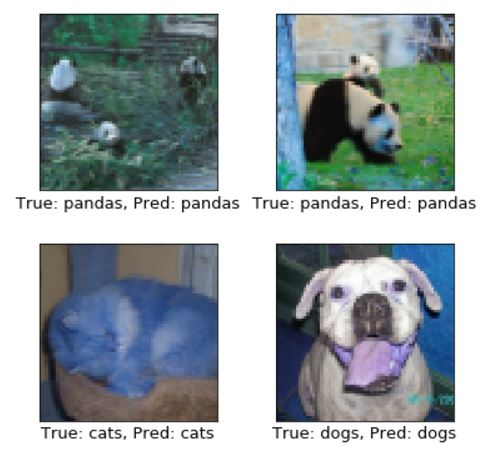

In [13]:
show_random_images(testX, true_class, predicted_class, show_incorrect=False)

Now let's set show_incorrect=True and let's take a look at the images that were classified incorrectly

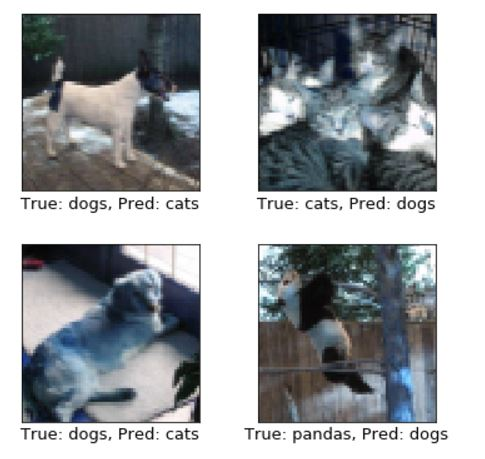

In [14]:
show_random_images(testX, true_class, predicted_class, show_incorrect=True)

Nice. I want to do one more thing before we're done. I want to take a picture of Banana, my own dog, and see if the model classifies her correctly. She's a very good looking dog however a lot of top-notch models often classify her as a squirrel or a cat, which makes her a good benchmark for our own classifier.

INFO:tensorflow:Restoring parameters from C:\Users\ggiorcelli\Tensorflow Workbooks\nn_animals

Predicted class:  ['dogs']


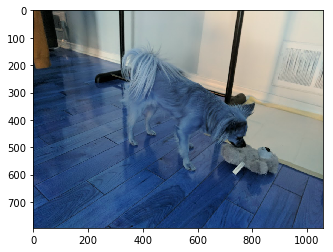

In [497]:
with tf.Session() as test_sess:
    
    test_sess.run(tf.global_variables_initializer())
    
    saver = tf.train.import_meta_graph('C:\\Users\\ggiorcelli\\Tensorflow Workbooks\\nn_animals.meta')
    saver.restore(test_sess, tf.train.latest_checkpoint('./'))

    graph = tf.get_default_graph()
 
    y_pred = graph.get_tensor_by_name("y_pred:0")
    y_pred_cls = tf.argmax(y_pred, axis=1)

    ## Restoring placeholders
    images_placeholder = graph.get_tensor_by_name("images_placeholder:0") 
    labels_placeholder = graph.get_tensor_by_name("labels_placeholder:0") 
    training = graph.get_tensor_by_name("training:0") 
    
    #load image
    path = 'C:\\Users\\ggiorcelli\\Tensorflow Workbooks\\test_images\\banana.jpg'
    image = cv2.imread(path)
    image_hidef = image.copy()
    image = np.expand_dims(image, axis=0)
    image = aspect_aware_resize(image, 64, 64, verbose=-1)
    image = process_image(image)
 
    #Generate prediction
    y_pred_cls = test_sess.run(y_pred_cls, feed_dict={images_placeholder: image, 
                                   #labels_placeholder: label,
                                   training: True})
    
    prediction = translate_labels(y_pred_cls)
    print("")
    print("Predicted class: ", prediction)
    plt.imshow(image_hidef)

That's great, Banana was classified correctly!

This is the end of the tutorial. I hope you enjoyed it and that you have learned some new AI skills that you can use on your own projects.

AI is a very complicated science that is changing a lot of aspects of our daily lives at a very fast pace. The entire AI community relies on knowledge-sharing and individual research in order to expand this science to new fields and to improve lives. If you have some experience with machine learning and/or deep learning, I hope you will consider building a tutorial like this in the future for everyone to enjoy and to learn from it.